In [ ]:
import sys
!{sys.executable} -m pip install xgboost



In [5]:
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


file_path = "df_rximages_final.csv"    #loading the dataset
df = pd.read_csv(file_path)

df.dropna(inplace=True)    #drop missing values if theres any

In [6]:
#encode categorical vars to nums so its easier to work with
label_encoders = {}
for column in ["shape", "color", "imprint", "name"]:  #'size'not included b/c it's numerical
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])  #converst text to nums
    label_encoders[column] = le  #stores encoders for decoding predictions


In [7]:
#defining features and target, X and y respectively
X = df[["shape", "color", "size", "imprint"]] #feature
y = df["name"] #target

In [ ]:
#timing the time it takes to train the model
start_time = time.time()

#train XGBoost model on 100% of the data
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  #configures the model for multi-class classification, 
                                #meaning it assigns each input to one of multiple possible pill names. 
                                #The "softmax" function ensures that the output probabilities across all classes sum to 1, 
                                #allowing the model to make a single definitive prediction.
    num_class=len(df["name"].unique()), #sets the number of unique pill names as the number of classes
    eval_metric="mlogloss",
    #n_estimators=500,  #increased number of trees for better learning
    #max_depth=25,  #increased depth for capturing more patterns
    n_estimators=750,
    max_depth=30,  
    learning_rate=0.03,  #lower learning rate = more refined training
    subsample=1.0,  #using full dataset to learn from all patterns bc it cant be generalized
    colsample_bytree=1.0,  #using all features in each tree
    min_child_weight=1,  #allow smaller splits
    reg_lambda=0,  #reducing regularization to allow more overfitting
    reg_alpha=0,  #reducing L1 regularization
    random_state=42
)
xgb_model.fit(X, y) #trains the XGBoost model on the entire dataset

training_time = time.time() - start_time #time took to train the model
print(f"Training time: {training_time:.4f} seconds")

Training time: 631.2486 seconds


In [9]:
#pill name predicting function
def predict_pill(shape, color, size, imprint):
    shape_encoded = label_encoders["shape"].transform([shape])[0] #convert shape to num
    color_encoded = label_encoders["color"].transform([color])[0] #convert color to num
    imprint_encoded = label_encoders["imprint"].transform([imprint])[0] #convert imprint to num
    #convert input to df with col names
    input_data = pd.DataFrame([[shape_encoded, color_encoded, size, imprint_encoded]], columns=X.columns)
    
    prediction = xgb_model.predict(input_data) #make a prediction using the trained model
    predicted_pill = label_encoders["name"].inverse_transform(prediction) #convert prediction back to the original pill name
    return predicted_pill[0] #return the predicted pill name

In [10]:
#example prediction
start_time = time.time()
example_prediction = predict_pill("CAPSULE", "GREEN", 20, "MYLAN;147;MYLAN;147")
print("Predicted Pill Name:", example_prediction)
prediction_time = time.time() - start_time
print(f"Prediction time: {prediction_time:.4f} seconds")

Predicted Pill Name: Indomethacin 50 MG Oral Capsule
Prediction time: 0.1501 seconds


In [11]:
#evaluate model performance on the training set
y_pred = xgb_model.predict(X)

In [12]:

#calculate accuracy
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")

#calculate precision 
precision = precision_score(y, y_pred, average="weighted", zero_division=1)
print(f"Precision Score: {precision:.4f}")

#calculate recall
recall = recall_score(y, y_pred, average="weighted", zero_division=1)
print(f"Recall Score: {recall:.4f}")

#calculate F1-score
f1 = f1_score(y, y_pred, average="weighted", zero_division=1)
print(f"F1 Score: {f1:.4f}")




Accuracy Score: 0.8849
Precision Score: 0.9245
Recall Score: 0.8849
F1 Score: 0.8621


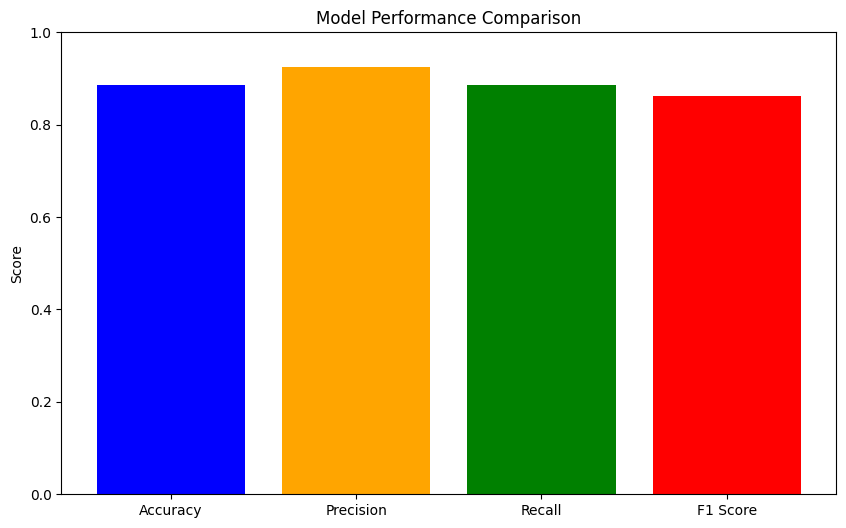

In [13]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()

In [ ]:
'''
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report


file_path = "df_rximages_final.csv"    # loading the dataset
df = pd.read_csv(file_path)

df.dropna(inplace=True)    # drop missing values if theres any

# encode categorical variables to numbers so its easier to work with
label_encoders = {}
for column in ["shape", "color", "imprint", "name"]:  #'size'not included b/c it's numerical
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])  #converst text to numbers
    label_encoders[column] = le  #stores encoders for decoding predictions

#defining features and target, X and y respectively
X = df[["shape", "color", "size", "imprint"]] #feature
y = df["name"] #target

#timing the time it takes to train the model
start_time = time.time()

#train XGBoost model on 100% of the data
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  #configures the model for multi-class classification, 
                                #meaning it assigns each input to one of multiple possible pill names. 
                                #The "softmax" function ensures that the output probabilities across all classes sum to 1, 
                                #allowing the model to make a single definitive prediction.
    num_class=len(df["name"].unique()), #sets the number of unique pill names as the number of classes
    eval_metric="mlogloss",
    #n_estimators=500,  #increased number of trees for better learning
    #max_depth=25,  #increased depth for capturing more patterns
    n_estimators=750,
    max_depth=30,  
    learning_rate=0.03,  #lower learning rate = more refined training
    subsample=1.0,  #using full dataset to learn from all patterns bc it cant be generalized
    colsample_bytree=1.0,  #using all features in each tree
    gamma=0,  # Allow more splits to improve learning
    min_child_weight=1,  #allow smaller splits
    reg_lambda=0,  #reducing regularization to allow more overfitting
    reg_alpha=0,  #reducing L1 regularization
    random_state=42
)
xgb_model.fit(X, y) #trains the XGBoost model on the entire dataset

training_time = time.time() - start_time #time took to train the model
print(f"Training time: {training_time:.4f} seconds")

#pill name predicting function
def predict_pill(shape, color, size, imprint):
    shape_encoded = label_encoders["shape"].transform([shape])[0] #convert shape to num
    color_encoded = label_encoders["color"].transform([color])[0] #convert color to num
    imprint_encoded = label_encoders["imprint"].transform([imprint])[0] #convert imprint to num
    #convert input to df with col names
    input_data = pd.DataFrame([[shape_encoded, color_encoded, size, imprint_encoded]], columns=X.columns)
    
    prediction = xgb_model.predict(input_data) #make a prediction using the trained model
    predicted_pill = label_encoders["name"].inverse_transform(prediction) #convert prediction back to the original pill name
    return predicted_pill[0] #return the predicted pill name

#example prediction
start_time = time.time()
example_prediction = predict_pill("CAPSULE", "GREEN", 20, "MYLAN;147;MYLAN;147")
print("Predicted Pill Name:", example_prediction)
prediction_time = time.time() - start_time
print(f"Prediction time: {prediction_time:.4f} seconds")
'''


